In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json manually

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavd99","key":"861e1a41925ba514802dc5fbb34c2db3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/walmart-recruiting-store-sales-forecasting
unzip:  cannot find or open walmart-recruiting-store-sales-forecasting.zip, walmart-recruiting-store-sales-forecasting.zip.zip or walmart-recruiting-store-sales-forecasting.zip.ZIP.


In [ ]:
!pip install prophet

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Load CSV files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

# Convert Date columns to datetime
for df in [train, test, features]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge datasets
train_merged = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
train_merged = train_merged.merge(stores, on='Store', how='left')

test_merged = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_merged = test_merged.merge(stores, on='Store', how='left')

In [ ]:
# You can change these to test other store/department combinations
STORE_ID = 1
DEPT_ID = 1

# Filter train data
train_df = train_merged[(train_merged['Store'] == STORE_ID) & (train_merged['Dept'] == DEPT_ID)]
train_df = train_df[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}).sort_values('ds')

In [ ]:
# Choose a cutoff to simulate "future" data
cutoff_date = train_df['ds'].max() - pd.Timedelta(weeks=6)

train_split = train_df[train_df['ds'] <= cutoff_date]
valid_split = train_df[train_df['ds'] > cutoff_date]

In [ ]:
# Choose a cutoff to simulate "future" data
cutoff_date = train_df['ds'].max() - pd.Timedelta(weeks=6)

train_split = train_df[train_df['ds'] <= cutoff_date]
valid_split = train_df[train_df['ds'] > cutoff_date]

In [ ]:
# Forecast for the dates in validation split
future = valid_split[['ds']]
forecast = model.predict(future)

# Combine predictions with actuals
result = forecast[['ds', 'yhat']].merge(valid_split.rename(columns={'y': 'actual'}), on='ds')

# Evaluate accuracy
mae = mean_absolute_error(result['actual'], result['yhat'])
rmse = np.sqrt(mean_squared_error(result['actual'], result['yhat']))
mape = np.mean(np.abs((result['actual'] - result['yhat']) / result['actual'])) * 100

print(f"📊 Validation Metrics for Store {STORE_ID}, Dept {DEPT_ID}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

📊 Validation Metrics for Store 1, Dept 1
MAE  = 2014.33
RMSE = 2407.72
MAPE = 8.52%


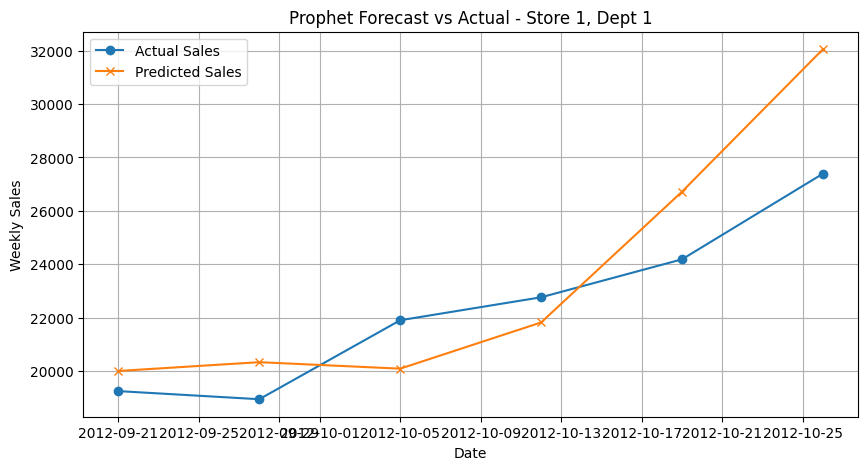

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(result['ds'], result['actual'], label='Actual Sales', marker='o')
plt.plot(result['ds'], result['yhat'], label='Predicted Sales', marker='x')
plt.title(f"Prophet Forecast vs Actual - Store {STORE_ID}, Dept {DEPT_ID}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()